# Brief Description
My final solution is based on ensemble of LGBM and SAKT, which give 0.786 on private leaderboard, 0.784 on public leaderboard. This notebook is only to train the single LGBM model.

### Features used to train the model

* raw features
    * prior_question_had_explanation
    * prior_question_elapsed_time
    * part

*Used raw data of prior question. As next step to improve the model, shift to get the data on current question.*

* question statistics without updates
    * content_total_questions
    * content_accuracy
    * content_accuracy_std
    * content_prior_question_elapsed_time_avg
    * content_prior_question_had_explanation_avg
    * content_explanation_false_mean
    * content_explanation_true_mean  

*The question statistics are calculated on complete train data, they are static aggregated dataframe, which is not updated during inferencing.*

* user statistics with updates
    * user_cum_total_questions
    * user_cum_accuracy
    * user_cum_prior_question_elapsed_time_avg
    * user_cum_prior_question_had_explanation_avg
    * user_cum_content_total_questions
    * user_ts_lag_1: lag between current timestamp and previous interaction
    * user_ts_lag_2: lag between current timestamp and previous 2 interaction
    * user_ts_lag_3: lag between current timestamp and previous 3 interaction
    * user_continuous_correct: previous continuous correct answers

*The user statistics are the states of the user at the moment of answering the question, calculated from user history (timestamp=0 to current time). Dictionaries are used to keep track of the statistics, and are updated during inferencing.*

*For next step, will take into account question difficulties (generate a feature on question accuracy and user accuracy). Also consider lag since previous correct/incorrect answer.*

### CV Strategy
CV method is based on tito's notebook https://www.kaggle.com/its7171/cv-strategy.  
This notebook uses last 50 million records from cv2_train, and filters only users with complete history (timestamp=0) to calculate features. And samples 14 million to train the model.
           




# Set Up

In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
from random import sample 
from collections import defaultdict
from tqdm import tqdm
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

import gc
import riiideducation

import os

gc.collect()

4

In [3]:
# Control parameters
FEATURE_ENGINEERING = False
RUN_CONTENT_AGG = False
DEBUG = False

# Load Data

In [4]:
def preprocess_df(path):
    cols = ['user_id', 'answered_correctly', 'content_id', \
        'prior_question_had_explanation', 'prior_question_elapsed_time', 'timestamp']
    df = pd.read_pickle(path)[cols].reset_index(drop=True)
    df = df[df.answered_correctly != -1]
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].fillna(0).astype('bool')
    prior_question_elapsed_time_mean = 25423.84 # mean of all train
    df['prior_question_elapsed_time'] = df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean)
    return df

# if calculating aggregated features of questions, set FEATURE_ENGINEERING to True
if FEATURE_ENGINEERING:
    train_path = "/kaggle/input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip"
else: 
    train_path = '../input/riiid-cross-validation-files/cv2_train.pickle'
    
val_path = '../input/riiid-cross-validation-files/cv2_valid.pickle'

train = preprocess_df(train_path)
val = preprocess_df(val_path)

print("Train size:", train.shape)
print('Validation size:', val.shape)

train.head()

Train size: (94365616, 6)
Validation size: (2451798, 6)


,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,timestamp
0,705741139,1,128,False,25423.839844,0
1,705741139,1,7860,False,16000.000000,20666
2,705741139,1,7922,False,19000.000000,39172
3,705741139,1,156,False,17000.000000,58207
4,705741139,1,51,False,17000.000000,75779


When training model, to avoid memory issue, use only last 50 million records, where the users have full history.

In [5]:
if not FEATURE_ENGINEERING:
    train = train[-50000000:]

    complete_user_id = train[train.timestamp==0]['user_id'].unique()
    train = train[train.user_id.isin(complete_user_id)]
    #train.drop('timestamp', axis=1, inplace=True)

    del complete_user_id
    gc.collect()

if DEBUG:
    train = train[:1000]
    val = val[:100]

print(train.shape)
train.info()
#train.memory_usage(deep=True)

(37203074, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37203074 entries, 45231422 to 96230331
Data columns (total 6 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   answered_correctly              int8   
 2   content_id                      int16  
 3   prior_question_had_explanation  bool   
 4   prior_question_elapsed_time     float32
 5   timestamp                       int64  
dtypes: bool(1), float32(1), int16(1), int32(1), int64(1), int8(1)
memory usage: 993.4 MB


In [6]:
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
questions['part'] = questions['part'].astype('int8')

# Feature Engineering

### Generate content features (static aggregation)

In [7]:
# content aggregation
def get_content_agg(train):
    content_agg = train.groupby('content_id').aggregate({'answered_correctly': ['count', np.nanmean, np.nanstd], \
                                                         'prior_question_elapsed_time': np.nanmean, \
                                                         'prior_question_had_explanation': np.nanmean})
    content_agg.columns = ['content_total_questions', \
                           'content_accuracy', \
                           'content_accuracy_std', \
                           'content_prior_question_elapsed_time_avg', \
                           'content_prior_question_had_explanation_avg']

    content_agg = content_agg.merge(questions[['question_id', 'part', 'bundle_id']], how='left', \
                           left_index=True, right_on='question_id').drop('question_id', axis=1)
    
    content_explanation_agg = train[["content_id","prior_question_had_explanation",'answered_correctly']].groupby(["content_id","prior_question_had_explanation"])['answered_correctly'].agg(['mean'])
    content_explanation_agg = content_explanation_agg.unstack()
    content_explanation_agg=content_explanation_agg.reset_index()
    content_explanation_agg.columns = ['content_id', 'content_explanation_false_mean','content_explanation_true_mean']
    
    content_agg = content_agg.merge(content_explanation_agg, how='left', \
                                   left_index=True, right_on='content_id'\
                                   ).drop('content_id', axis=1)

    column_type = {'content_total_questions':'int64', \
                   'content_accuracy': 'float16',\
                   'content_accuracy_std':'float32', \
                   'content_prior_question_elapsed_time_avg': 'float32', \
                   'content_prior_question_had_explanation_avg': 'float16', \
                   'part': 'int8', \
                   'bundle_id':'int16', \
                   'content_explanation_false_mean': 'float16', \
                   'content_explanation_true_mean': 'float16'}
    content_agg = content_agg.astype(column_type)
    
    content_agg.to_pickle('content_agg.pkl')   
    return content_agg

if RUN_CONTENT_AGG:
    content_agg = get_content_agg(train)

else:
    # saved content_agg is calculated on all train
    content_agg = pd.read_pickle('/kaggle/input/riid-budingtanke/content_agg_3.pkl')

content_agg = content_agg[['content_total_questions', \
                           'content_accuracy', \
                           'content_accuracy_std', \
                           'content_prior_question_elapsed_time_avg', \
                           'content_prior_question_had_explanation_avg', \
                           'part', \
                           'bundle_id', \
                           'content_explanation_false_mean', \
                           'content_explanation_true_mean']]

content_agg.head()

,content_total_questions,content_accuracy,content_accuracy_std,content_prior_question_elapsed_time_avg,content_prior_question_had_explanation_avg,part,bundle_id,content_explanation_false_mean,content_explanation_true_mean
0,6903,0.907715,0.289440,21876.357422,0.947754,1,0,0.830566,0.912109
1,7398,0.890625,0.312104,22091.626953,0.980469,1,1,0.813965,0.892090
2,44905,0.554199,0.497050,23546.447266,0.888184,1,2,0.490967,0.562012
3,22973,0.779297,0.414636,23318.945312,0.958496,1,3,0.686035,0.783691
4,31736,0.613281,0.487021,23126.990234,0.530273,1,4,0.566895,0.654297


### Generate user features

In [8]:
# create defaultdict to keep track of user statistics
dict_user_total_questions = defaultdict(int)
dict_user_correct_questions = defaultdict(int)
dict_user_prior_question_elapsed_time_sum = defaultdict(int)
dict_user_prior_question_had_explanation_sum = defaultdict(int)
dict_user_content_total_questions = defaultdict(lambda: defaultdict(int))
dict_user_previous_ts = defaultdict(list)
dict_user_continuous_correct = defaultdict(int)

In [9]:
# function to add features
def get_features(df, \
                 dict_user_total_questions, \
                 dict_user_correct_questions, \
                 dict_user_prior_question_elapsed_time_sum, \
                 dict_user_prior_question_had_explanation_sum, \
                 dict_user_content_total_questions, \
                 dict_user_previous_ts, \
                 dict_user_continuous_correct):
    
    user_cum_total_questions = np.zeros(df.shape[0], dtype=np.int32)
    user_cum_accuracy = np.zeros(df.shape[0], dtype=np.float32)
    user_cum_prior_question_elapsed_time_avg = np.zeros(df.shape[0], dtype=np.float32)
    user_cum_prior_question_had_explanation_avg = np.zeros(df.shape[0], dtype=np.float32)
    user_cum_content_total_questions = np.zeros(df.shape[0], dtype=np.int32)  
    user_ts_lag_1 = np.zeros(df.shape[0], dtype = np.float32)
    user_ts_lag_2 = np.zeros(df.shape[0], dtype = np.float32)
    user_ts_lag_3 = np.zeros(df.shape[0], dtype = np.float32)
    user_continuous_correct = np.zeros(df.shape[0], dtype = np.float16)
    
    for i, row in enumerate(tqdm(df[['user_id', \
                                     'answered_correctly', \
                                     'prior_question_elapsed_time', \
                                     'prior_question_had_explanation', \
                                     'content_id', \
                                     'timestamp']].values)):
        # get features from dicts
        user_cum_total_questions[i] = dict_user_total_questions[row[0]]
        if dict_user_total_questions[row[0]] != 0:      
            user_cum_accuracy[i] = dict_user_correct_questions[row[0]]/dict_user_total_questions[row[0]]
            user_cum_prior_question_elapsed_time_avg[i] = dict_user_prior_question_elapsed_time_sum[row[0]]/dict_user_total_questions[row[0]]
            user_cum_prior_question_had_explanation_avg[i] = dict_user_prior_question_had_explanation_sum[row[0]]/dict_user_total_questions[row[0]]
        else:
            user_cum_accuracy[i] = np.nan 
            user_cum_prior_question_elapsed_time_avg[i] = np.nan 
            user_cum_prior_question_had_explanation_avg[i] = np.nan
        
        user_cum_content_total_questions[i] = dict_user_content_total_questions[row[0]][row[4]]
        
        if len(dict_user_previous_ts[row[0]]) == 0:
            user_ts_lag_1[i] = np.nan
            user_ts_lag_2[i] = np.nan
            user_ts_lag_3[i] = np.nan
        elif len(dict_user_previous_ts[row[0]]) == 1:
            user_ts_lag_1[i] = row[5] - dict_user_previous_ts[row[0]][0]
            user_ts_lag_2[i] = np.nan
            user_ts_lag_3[i] = np.nan
        elif len(dict_user_previous_ts[row[0]]) == 2:
            user_ts_lag_1[i] = row[5] - dict_user_previous_ts[row[0]][1]
            user_ts_lag_2[i] = row[5] - dict_user_previous_ts[row[0]][0]
            user_ts_lag_3[i] = np.nan
        elif len(dict_user_previous_ts[row[0]]) == 3:
            user_ts_lag_1[i] = row[5] - dict_user_previous_ts[row[0]][2]
            user_ts_lag_2[i] = row[5] - dict_user_previous_ts[row[0]][1]
            user_ts_lag_3[i] = row[5] - dict_user_previous_ts[row[0]][0]
            
        if row[5] == 0:
            user_continuous_correct[i] = np.nan
        else:
            user_continuous_correct[i] = dict_user_continuous_correct[row[0]]
        

        # update dicts
        dict_user_total_questions[row[0]] += 1
        dict_user_correct_questions[row[0]] += row[1]
        dict_user_prior_question_elapsed_time_sum[row[0]] += row[2]
        dict_user_prior_question_had_explanation_sum[row[0]] += row[3]
        dict_user_content_total_questions[row[0]][row[4]] += 1
        
        if len(dict_user_previous_ts[row[0]]) == 3:
            dict_user_previous_ts[row[0]].pop(0)
            dict_user_previous_ts[row[0]].append(row[5])
        else:
            dict_user_previous_ts[row[0]].append(row[5])
            
        if row[1] == 0:
            dict_user_continuous_correct[row[0]] = 0
        else:
            dict_user_continuous_correct[row[0]] += 1
            
    
    df.drop(['timestamp'], axis=1, inplace=True)
    df.reset_index(drop=True)
    
    # add new features to df
    df['user_cum_total_questions'] = user_cum_total_questions
    df['user_cum_accuracy'] = user_cum_accuracy
    df['user_cum_prior_question_elapsed_time_avg'] = user_cum_prior_question_elapsed_time_avg
    df['user_cum_prior_question_had_explanation_avg'] = user_cum_prior_question_had_explanation_avg
    df['user_cum_content_total_questions'] = user_cum_content_total_questions
    
    df['user_ts_lag_1'] = user_ts_lag_1
    df['user_ts_lag_2'] = user_ts_lag_2
    df['user_ts_lag_3'] = user_ts_lag_3
    
    df['user_continuous_correct'] = user_continuous_correct

    del user_cum_total_questions
    del user_cum_accuracy
    del user_cum_prior_question_elapsed_time_avg
    del user_cum_prior_question_had_explanation_avg
    del user_cum_content_total_questions
    del user_ts_lag_1
    del user_ts_lag_2
    del user_ts_lag_3
    del user_continuous_correct
    
    gc.collect()

    return df

In [10]:
# add user features to train data
train = get_features(train, \
                     dict_user_total_questions, \
                     dict_user_correct_questions, \
                     dict_user_prior_question_elapsed_time_sum, \
                     dict_user_prior_question_had_explanation_sum, \
                     dict_user_content_total_questions, \
                     dict_user_previous_ts, \
                     dict_user_continuous_correct)

train.head()
time.sleep(15)

100%|██████████| 37203074/37203074 [09:49<00:00, 63133.91it/s]


In [11]:
# to avoid memory issue, sample 14 million to train model
train = train.sample(n=14000000, random_state = 45).reset_index(drop=True)
time.sleep(15)

In [12]:
# add user features to validation data
val = get_features(val, \
                   dict_user_total_questions, \
                   dict_user_correct_questions, \
                   dict_user_prior_question_elapsed_time_sum, \
                   dict_user_prior_question_had_explanation_sum, \
                   dict_user_content_total_questions, \
                   dict_user_previous_ts, \
                   dict_user_continuous_correct)

# val.head()

100%|██████████| 2451798/2451798 [00:38<00:00, 63043.61it/s]


In [13]:
del dict_user_total_questions
del dict_user_correct_questions
del dict_user_prior_question_elapsed_time_sum 
del dict_user_prior_question_had_explanation_sum
del dict_user_content_total_questions
del dict_user_previous_ts
del dict_user_continuous_correct

gc.collect()

20

In [14]:
# join content features
train = train.merge(content_agg, right_index=True, left_on='content_id', how='left')
val = val.merge(content_agg, right_index=True, left_on='content_id', how='left')

del content_agg
gc.collect()

20

In [15]:
train.head()

,user_id,answered_correctly,content_id,prior_question_had_explanation,prior_question_elapsed_time,user_cum_total_questions,user_cum_accuracy,user_cum_prior_question_elapsed_time_avg,user_cum_prior_question_had_explanation_avg,user_cum_content_total_questions,...,user_continuous_correct,content_total_questions,content_accuracy,content_accuracy_std,content_prior_question_elapsed_time_avg,content_prior_question_had_explanation_avg,part,bundle_id,content_explanation_false_mean,content_explanation_true_mean
0,772075662,0,8616,True,31000.0,517,0.471954,38214.855469,0.969052,0,...,1.0,7302,0.690918,0.462095,24878.833984,0.993652,5,8616,0.600098,0.691406
1,540159398,1,2089,True,2333.0,2304,0.717882,16089.218750,0.996528,0,...,1.0,3827,0.829102,0.376463,23174.623047,0.968750,3,2087,0.856934,0.828125
2,1689132890,1,11314,True,25000.0,89,0.719101,20195.773438,0.898876,0,...,5.0,2799,0.851562,0.355428,25395.830078,0.992676,5,11314,0.799805,0.852051
3,1843409667,1,2387,True,666.0,1998,0.777778,24376.310547,0.969469,1,...,5.0,13091,0.790527,0.406882,24562.880859,0.968262,3,2386,0.781738,0.791016
4,1276725128,1,6004,True,10000.0,758,0.641161,18200.142578,0.957784,0,...,0.0,23022,0.645020,0.478566,24879.576172,0.971680,5,6004,0.534668,0.647949


# Model

In [16]:
target = 'answered_correctly'
features = [# raw features
            'prior_question_had_explanation', \
            'prior_question_elapsed_time', \
            # user statistics with updates
            'user_cum_total_questions', \
            'user_cum_accuracy', \
            'user_cum_prior_question_elapsed_time_avg', \
            'user_cum_prior_question_had_explanation_avg', \
            'user_cum_content_total_questions', \
            # question statistics without updates
            'content_total_questions', \
            'content_accuracy', \
            'content_accuracy_std', \
            'content_prior_question_elapsed_time_avg', \
            'content_prior_question_had_explanation_avg', \
            'content_explanation_false_mean', \
            'content_explanation_true_mean', \
            # user statistics with updates
            'user_ts_lag_1', \
            'user_ts_lag_2', \
            'user_ts_lag_3', \
            'user_continuous_correct', \
            'part' 
           ]
train = train[features + [target]]
val = val[features + [target]]

In [17]:
train['content_total_questions'] = np.array(train['content_total_questions'], dtype=np.int32)
train['part'] = np.array(train['part'], dtype=np.int8)
train['content_accuracy'] = np.array(train['content_accuracy'], dtype=np.float32)

val['content_total_questions'] = np.array(val['content_total_questions'], dtype=np.int32)
val['part'] = np.array(val['part'], dtype=np.int8)
val['content_accuracy'] = np.array(val['content_accuracy'], dtype=np.float32)

In [18]:
lgb_train = lgb.Dataset(train[features], train[target])
lgb_val = lgb.Dataset(val[features], val[target])

del train, val
gc.collect()
time.sleep(20)

In [19]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          'boosting_type': "gbdt", #default,
          'bagging_fraction': 0.8,
          "bagging_seed": 11,
          'max_bin':320, # default 255
          'num_leaves': 200 # default 31
         }

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_val],
    verbose_eval=20,
    num_boost_round=10000,
    early_stopping_rounds=8
#     categorical_feature=categorical_columns
)

# [377]	training's auc: 0.782873	valid_1's auc: 0.78099

Training until validation scores don't improve for 8 rounds
[20]	training's auc: 0.766702	valid_1's auc: 0.769664
[40]	training's auc: 0.771929	valid_1's auc: 0.774375
[60]	training's auc: 0.774771	valid_1's auc: 0.776769
[80]	training's auc: 0.776406	valid_1's auc: 0.778062
[100]	training's auc: 0.77757	valid_1's auc: 0.778952
[120]	training's auc: 0.778275	valid_1's auc: 0.779391
[140]	training's auc: 0.778808	valid_1's auc: 0.779674
[160]	training's auc: 0.779147	valid_1's auc: 0.779772
[180]	training's auc: 0.779584	valid_1's auc: 0.779934
[200]	training's auc: 0.779988	valid_1's auc: 0.780094
[220]	training's auc: 0.780407	valid_1's auc: 0.780256
[240]	training's auc: 0.780715	valid_1's auc: 0.780358
[260]	training's auc: 0.780985	valid_1's auc: 0.78045
[280]	training's auc: 0.781408	valid_1's auc: 0.780623
[300]	training's auc: 0.781742	valid_1's auc: 0.780727
[320]	training's auc: 0.782051	valid_1's auc: 0.780805
[340]	training's auc: 0.78235	valid_1's auc: 0.780881
[360]	traini

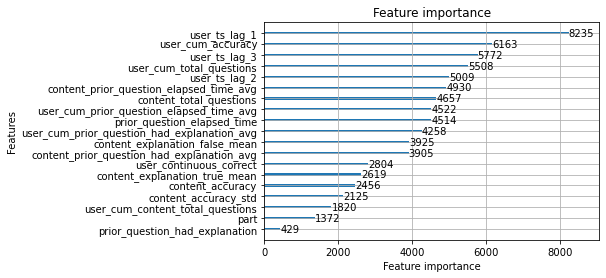

In [20]:
model.save_model('model.txt')

lgb.plot_importance(model) 
plt.show()

In [21]:
#model = lgb.Booster(model_file='/kaggle/input/riid-budingtanke/model.txt')